In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
import seaborn as sns

# 0. Data

Source & Description: https://archive.ics.uci.edu/dataset/352/online+retail

In [6]:
df = pd.read_csv("./data.csv")

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [8]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df = df.dropna(subset=['CustomerID'])

In [10]:
df.shape

(406829, 8)

In [11]:
df["StockCode"].nunique()

3684

In [12]:
df["CustomerID"].nunique()

4372

In [13]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

/var/folders/d8/vt448d1x2wn2xr6nz4lhnlbh0000gn/T/ipykernel_8955/3012402086.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [14]:
df["InvoiceDate"].describe()

count                           406829
mean     2011-07-10 16:30:57.879207424
min                2010-12-01 08:26:00
25%                2011-04-06 15:02:00
50%                2011-07-31 11:48:00
75%                2011-10-20 13:06:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [15]:
%%time

customer_item_matrix = df.pivot_table(
    index='CustomerID', 
    columns='StockCode', 
    values='Quantity',
    aggfunc='sum'
)

CPU times: user 109 ms, sys: 26.3 ms, total: 135 ms
Wall time: 142 ms


In [16]:
customer_item_matrix.shape

(4372, 3684)

In [17]:
%%time

customer_item_matrix = customer_item_matrix.map(lambda x: 1 if x > 0 else 0)

CPU times: user 2.09 s, sys: 76 ms, total: 2.16 s
Wall time: 2.21 s


In [18]:
customer_item_matrix.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# 1. Market Basket Analysis

In [19]:
# pip install mlxtend

In [20]:
from mlxtend.frequent_patterns import apriori, association_rules

In [21]:
at_least_100_sold_items = customer_item_matrix.columns[(customer_item_matrix.sum() > 100)]
at_least_100_sold_items

Index(['15036', '15056BL', '15056N', '16156S', '16161P', '16161U', '16169E',
       '16237', '17003', '20668',
       ...
       '85099B', '85099C', '85099F', '85123A', '85150', '85152', '85184C',
       '85227', 'M', 'POST'],
      dtype='object', name='StockCode', length=904)

In [22]:
at_least_20_purchase_customers = customer_item_matrix.loc[(customer_item_matrix[at_least_100_sold_items].sum(axis=1) >= 20)].index
at_least_20_purchase_customers

Index([12347.0, 12349.0, 12352.0, 12354.0, 12356.0, 12357.0, 12359.0, 12360.0,
       12362.0, 12364.0,
       ...
       18248.0, 18252.0, 18257.0, 18259.0, 18260.0, 18263.0, 18265.0, 18272.0,
       18283.0, 18287.0],
      dtype='float64', name='CustomerID', length=2519)

In [23]:
mb_matrix = customer_item_matrix.loc[at_least_20_purchase_customers][at_least_100_sold_items]
mb_matrix.shape

(2519, 904)

## 1.1. Apriori - Frequent Item Sets

In [24]:
%%time

frequent_items = apriori(
    customer_item_matrix, 
    min_support=0.03,
    use_colnames=True
)

/opt/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


CPU times: user 2.21 s, sys: 1.36 s, total: 3.57 s
Wall time: 4.1 s


In [25]:
frequent_items["n_items"] = frequent_items["itemsets"].apply(lambda x: len(x))

In [26]:
frequent_items

,support,itemsets,n_items
0,0.044145,(15036),1
1,0.032479,(15056BL),1
2,0.042086,(15056N),1
3,0.030878,(16156S),1
4,0.043001,(16161P),1
...,...,...,...
1951,0.034309,"(22384, 20725, 20728, 22383, 20727)",5
1952,0.032022,"(22384, 20725, 22382, 22383, 20727)",5
1953,0.033166,"(22384, 20725, 22382, 20728, 22383)",5
1954,0.030192,"(20725, 22382, 20728, 22383, 23207)",5


In [27]:
frequent_items["support"].describe()

count    1956.000000
mean        0.042293
std         0.016682
min         0.030192
25%         0.032479
50%         0.036597
75%         0.045059
max         0.198994
Name: support, dtype: float64

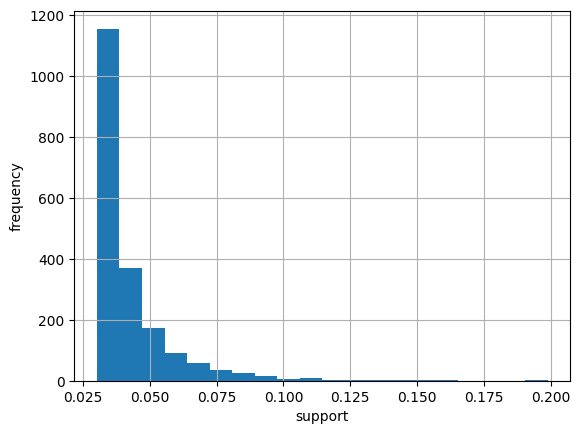

In [28]:
ax = frequent_items["support"].hist(bins=20)
ax.set_xlabel("support")
ax.set_ylabel("frequency")
plt.show()

## 1.2. Association Rules

In [29]:
rules = association_rules(
    frequent_items, 
    metric="confidence",
    min_threshold=0.6, 
    support_only=False
)

In [30]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(20712),(85099B),0.056267,0.144556,0.038655,0.686992,4.752418,0.030521,2.732976,0.836657
1,(20713),(85099B),0.047118,0.144556,0.034309,0.728155,5.037176,0.027498,3.146811,0.841107
2,(20719),(20724),0.054209,0.076624,0.037283,0.687764,8.975830,0.033129,2.957299,0.939520
3,(20723),(20724),0.052150,0.076624,0.037740,0.723684,9.444619,0.033744,3.341742,0.943313
4,(20723),(22355),0.052150,0.056496,0.031336,0.600877,10.635770,0.028390,2.363944,0.955824
...,...,...,...,...,...,...,...,...,...,...
2019,"(22384, 22383, 20727)","(20728, 22382)",0.043916,0.064273,0.031565,0.718750,11.182829,0.028742,3.327031,0.952403
2020,"(22383, 20728, 22382)","(22384, 20727)",0.047575,0.063586,0.031565,0.663462,10.434007,0.028539,2.782486,0.949324
2021,"(20728, 22382, 20727)","(22384, 22383)",0.044145,0.055124,0.031565,0.715026,12.971341,0.029131,3.315657,0.965530
2022,"(22383, 22382, 20727)","(22384, 20728)",0.046661,0.064730,0.031565,0.676471,10.450634,0.028544,2.890834,0.948573


In [31]:
most_lift = rules.sort_values(by="lift", ascending=False).head(20).pivot_table(
    index='antecedents', 
    columns='consequents', 
    values='lift',
    aggfunc='sum'
)

most_lift.index = [
    " + ".join([df.loc[df["StockCode"] == item]["Description"].unique()[0] for item in list(x)]) for x in most_lift.index
]

most_lift.columns = [
    " + ".join([df.loc[df["StockCode"] == item]["Description"].unique()[0] for item in list(x)]) for x in most_lift.columns
]

In [32]:
most_lift

,REGENCY TEA PLATE GREEN + ROSES REGENCY TEACUP AND SAUCER,REGENCY TEA PLATE ROSES + GREEN REGENCY TEACUP AND SAUCER,REGENCY TEA PLATE PINK,REGENCY TEA PLATE ROSES + REGENCY TEA PLATE GREEN,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE GREEN + GREEN REGENCY TEACUP AND SAUCER,REGENCY TEA PLATE PINK + GREEN REGENCY TEACUP AND SAUCER,REGENCY TEA PLATE ROSES + REGENCY TEA PLATE PINK,REGENCY TEA PLATE ROSES + ROSES REGENCY TEACUP AND SAUCER,REGENCY TEA PLATE ROSES + GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER
REGENCY TEA PLATE ROSES + GREEN REGENCY TEACUP AND SAUCER,26.010726,NaN,NaN,NaN,NaN,NaN,20.839579,NaN,NaN,NaN,NaN,NaN
REGENCY TEA PLATE GREEN + ROSES REGENCY TEACUP AND SAUCER,NaN,26.010726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REGENCY TEA PLATE ROSES + REGENCY TEA PLATE GREEN,NaN,NaN,22.386747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REGENCY TEA PLATE PINK,NaN,NaN,NaN,22.386747,NaN,NaN,20.879103,21.993293,NaN,NaN,NaN,NaN
SET/6 RED SPOTTY PAPER PLATES,NaN,NaN,NaN,NaN,22.230756,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SET/6 RED SPOTTY PAPER CUPS,NaN,NaN,NaN,NaN,NaN,22.230756,NaN,NaN,NaN,NaN,NaN,NaN
REGENCY TEA PLATE GREEN + GREEN REGENCY TEACUP AND SAUCER,NaN,NaN,21.993293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.462228,NaN
REGENCY TEA PLATE PINK + GREEN REGENCY TEACUP AND SAUCER,NaN,NaN,NaN,NaN,NaN,NaN,21.761086,NaN,NaN,NaN,NaN,NaN
REGENCY TEA PLATE GREEN,NaN,20.839579,20.879103,NaN,NaN,NaN,NaN,NaN,21.761086,21.473167,NaN,20.945479
REGENCY TEA PLATE ROSES + REGENCY TEA PLATE PINK,NaN,NaN,NaN,NaN,NaN,NaN,21.473167,NaN,NaN,NaN,NaN,NaN


In [33]:
most_conf = rules.sort_values(by="confidence", ascending=False).head(20).pivot_table(
    index='antecedents', 
    columns='consequents', 
    values='confidence',
    aggfunc='sum'
)

most_conf.index = [
    " + ".join([df.loc[df["StockCode"] == item]["Description"].unique()[0] for item in list(x)]) for x in most_conf.index
]

most_conf.columns = [
    " + ".join([df.loc[df["StockCode"] == item]["Description"].unique()[0] for item in list(x)]) for x in most_conf.columns
]

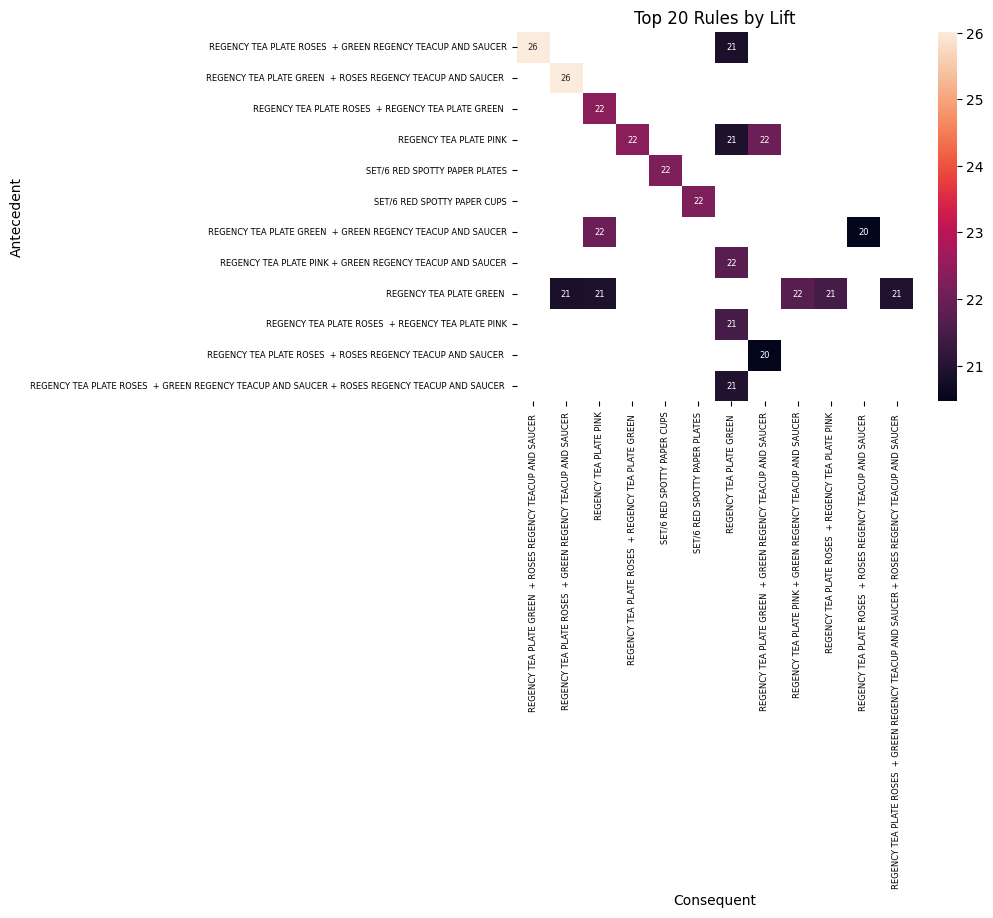

In [34]:
ax = plt.subplot()
sns.heatmap(
    most_lift, 
    annot=True, 
    annot_kws={"size": 6},
    # fmt=".1f", 
    ax=ax
)
ax.set_title("Top 20 Rules by Lift")
ax.set_xlabel("Consequent")
ax.set_ylabel("Antecedent")
ax.yaxis.set_ticklabels(list(most_lift.index), fontsize=6)
ax.xaxis.set_ticklabels(list(most_lift.columns), fontsize=6)
plt.show()

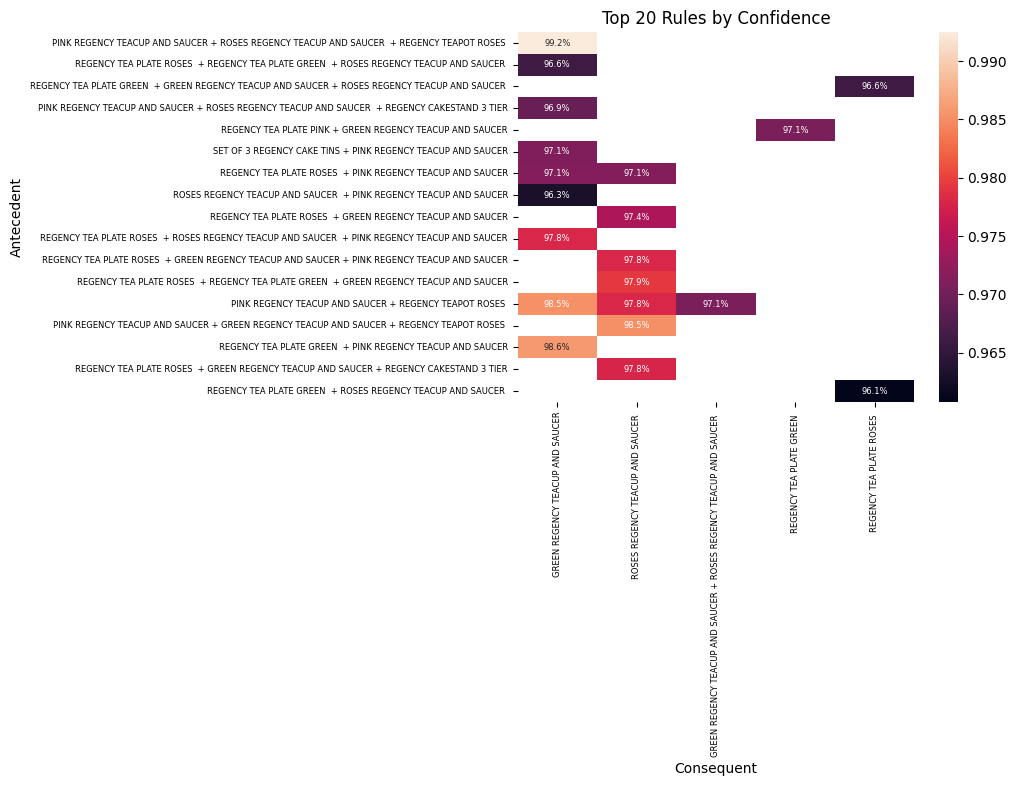

In [35]:
ax = plt.subplot()
sns.heatmap(
    most_conf, 
    annot=True, 
    annot_kws={"size": 6},
    fmt=".1%", 
    ax=ax
)
ax.set_title("Top 20 Rules by Confidence")
ax.set_xlabel("Consequent")
ax.set_ylabel("Antecedent")
ax.yaxis.set_ticklabels(list(most_conf.index), fontsize=6)
ax.xaxis.set_ticklabels(list(most_conf.columns), fontsize=6)
plt.show()

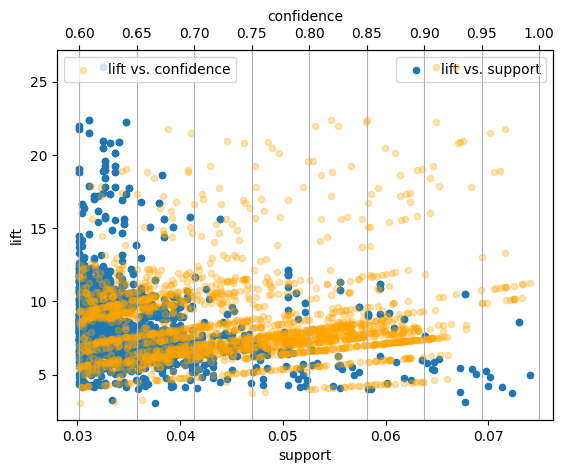

In [36]:
# linear with confidence & inverse with support as lift = confidence / support

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

rules[["support","lift"]].plot(
    kind="scatter", x="support", y="lift", ax=ax1
)
rules[["confidence","lift"]].plot(
    kind="scatter", x="confidence", y="lift", ax=ax2, color="orange", alpha=0.3
)

ax1.legend(["lift vs. support",], loc="upper right")
ax2.legend(["lift vs. confidence",], loc="upper left")
plt.grid()
plt.show()

# 2. Collaborative Filtering

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

## 2.1. User-Based Collaborative Filtering

### 2.1.1. CF Training

In [38]:
%%time

user_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix)
)

CPU times: user 5.41 s, sys: 876 ms, total: 6.29 s
Wall time: 295 ms


In [39]:
user_user_sim_matrix.shape

(4372, 4372)

In [40]:
user_user_sim_matrix.columns = customer_item_matrix.index

user_user_sim_matrix['CustomerID'] = customer_item_matrix.index
user_user_sim_matrix = user_user_sim_matrix.set_index('CustomerID')

In [41]:
user_user_sim_matrix.loc[
    [12347.0, 12348.0, 12349.0, 12350.0, 12352.0],
    [12347.0, 12348.0, 12349.0, 12350.0, 12352.0]
]

CustomerID,12347.0,12348.0,12349.0,12350.0,12352.0
CustomerID,,,,,
12347.0,1.000000,0.063022,0.046130,0.047795,0.038814
12348.0,0.063022,1.000000,0.024953,0.051709,0.027995
12349.0,0.046130,0.024953,1.000000,0.056773,0.138314
12350.0,0.047795,0.051709,0.056773,1.000000,0.031846
12352.0,0.038814,0.027995,0.138314,0.031846,1.000000


### 2.1.2. Making Recommendations

In [42]:
TARGET_CUSTOMER = 14806.0

In [43]:
print("Similar Customers to TARGET")
user_user_sim_matrix.loc[TARGET_CUSTOMER].sort_values(ascending=False).head(10)

Similar Customers to TARGET


CustomerID
14806.0    1.000000
13919.0    0.251478
12561.0    0.226134
13711.0    0.181818
12618.0    0.181818
13116.0    0.165145
12497.0    0.161165
17475.0    0.161165
12372.0    0.155126
14840.0    0.150756
Name: 14806.0, dtype: float64

In [44]:
items_bought_by_target = set(
    df.loc[
        df["CustomerID"] == TARGET_CUSTOMER
    ]["StockCode"].unique()
)
items_bought_by_target

{'21499',
 '21500',
 '22704',
 '22711',
 '23079',
 '23232',
 '23550',
 '72351B',
 '84508C',
 '84580',
 '85175'}

#### Recommending by the most similar customer

In [45]:
items_bought_by_sim = set(
    df.loc[
        df["CustomerID"] == 13919.0
    ]["StockCode"].unique()
)
items_bought_by_sim

{'16161P',
 '16161U',
 '16169E',
 '21498',
 '21499',
 '21500',
 '21731',
 '22046',
 '22567',
 '22666',
 '22704',
 '22707',
 '22711',
 '22847',
 '22961',
 '23233',
 '23511',
 '23512',
 '23513',
 '23515',
 '23518',
 '23546',
 '23547',
 'POST'}

In [46]:
items_bought_by_sim_but_not_by_target = items_bought_by_sim - items_bought_by_target
df.loc[
    df["StockCode"].isin(items_bought_by_sim_but_not_by_target)
][["StockCode", "Description"]].drop_duplicates()

,StockCode,Description
39,21731,RED TOADSTOOL LED NIGHT LIGHT
45,POST,POSTAGE
105,22961,JAM MAKING SET PRINTED
1217,21498,RED RETROSPOT WRAP
1296,22666,RECIPE BOX PANTRY YELLOW DESIGN
1299,22567,20 DOLLY PEGS RETROSPOT
2116,22847,BREAD BIN DINER STYLE IVORY
5016,16161P,WRAP ENGLISH ROSE
9525,16161U,WRAP SUKI AND FRIENDS
9780,22847,"BREAD BIN, DINER STYLE, IVORY"


#### Recommending by Similar Sums

In [47]:
top10_similar_users = user_user_sim_matrix.loc[TARGET_CUSTOMER].sort_values(ascending=False).head(11).to_dict()
top10_similar_users

{14806.0: 1.0,
 13919.0: 0.2514778453847726,
 12561.0: 0.22613350843332272,
 13711.0: 0.18181818181818182,
 12618.0: 0.18181818181818182,
 13116.0: 0.1651445647689541,
 12497.0: 0.16116459280507606,
 17475.0: 0.16116459280507606,
 12372.0: 0.15512630699850574,
 14840.0: 0.15075567228888181,
 15160.0: 0.15075567228888181}

In [48]:
potential_rec_items = {}
for user, cos_sim in top10_similar_users.items():
    if user == TARGET_CUSTOMER:
        continue
        
    items_bought_by_sim = list(set(
        df.loc[
            df["CustomerID"] == user
        ]["StockCode"].unique()
    ))

    for each_item in items_bought_by_sim:
        if each_item not in potential_rec_items:
            potential_rec_items[each_item] = 0
        potential_rec_items[each_item] += cos_sim

potential_rec_items = [(key, val) for key, val in potential_rec_items.items()]
potential_rec_items = sorted(potential_rec_items, key=lambda x: x[1], reverse=True)

In [49]:
potential_rec_items[:10]

[('21499', 1.328721467833565),
 ('21500', 1.328721467833565),
 ('21498', 0.8039205113921255),
 ('POST', 0.7495869270065362),
 ('22704', 0.632737660816601),
 ('16161U', 0.5677687451883544),
 ('22138', 0.4981090816217636),
 ('22711', 0.4066041523832783),
 ('22631', 0.38125981543182846),
 ('22326', 0.38125981543182846)]

In [50]:
top_10_items = [x[0] for x in potential_rec_items[:10]]
df.loc[
    df["StockCode"].isin(top_10_items)
][["StockCode", "Description"]].drop_duplicates().set_index(
    "StockCode"
).loc[top_10_items]

,Description
StockCode,
21499,BLUE POLKADOT WRAP
21500,PINK POLKADOT WRAP
21498,RED RETROSPOT WRAP
POST,POSTAGE
22704,WRAP RED APPLES
16161U,WRAP SUKI AND FRIENDS
22138,BAKING SET 9 PIECE RETROSPOT
22711,WRAP CIRCUS PARADE
22631,CIRCUS PARADE LUNCH BOX


#### Recommending by Most Bought by Similar Customers

In [51]:
top10_similar_users = user_user_sim_matrix.loc[TARGET_CUSTOMER].sort_values(ascending=False).head(11).to_dict()
top10_similar_users

{14806.0: 1.0,
 13919.0: 0.2514778453847726,
 12561.0: 0.22613350843332272,
 13711.0: 0.18181818181818182,
 12618.0: 0.18181818181818182,
 13116.0: 0.1651445647689541,
 12497.0: 0.16116459280507606,
 17475.0: 0.16116459280507606,
 12372.0: 0.15512630699850574,
 14840.0: 0.15075567228888181,
 15160.0: 0.15075567228888181}

In [52]:
potential_rec_items = {}
for user, cos_sim in top10_similar_users.items():
    if user == TARGET_CUSTOMER:
        continue
        
    items_bought_by_sim = list(set(
        df.loc[
            df["CustomerID"] == user
        ]["StockCode"].unique()
    ))

    for each_item in items_bought_by_sim:
        if each_item not in potential_rec_items:
            potential_rec_items[each_item] = 0
        potential_rec_items[each_item] += 1

potential_rec_items = [(key, val) for key, val in potential_rec_items.items()]
potential_rec_items = sorted(potential_rec_items, key=lambda x: x[1], reverse=True)

In [53]:
potential_rec_items[:10]

[('21499', 7),
 ('21500', 7),
 ('21498', 4),
 ('POST', 4),
 ('16161U', 3),
 ('22704', 3),
 ('22138', 3),
 ('22711', 2),
 ('22631', 2),
 ('22326', 2)]

In [54]:
top_10_items = [x[0] for x in potential_rec_items[:10]]
df.loc[
    df["StockCode"].isin(top_10_items)
][["StockCode", "Description"]].drop_duplicates().set_index(
    "StockCode"
).loc[top_10_items]

,Description
StockCode,
21499,BLUE POLKADOT WRAP
21500,PINK POLKADOT WRAP
21498,RED RETROSPOT WRAP
POST,POSTAGE
16161U,WRAP SUKI AND FRIENDS
22704,WRAP RED APPLES
22138,BAKING SET 9 PIECE RETROSPOT
22711,WRAP CIRCUS PARADE
22631,CIRCUS PARADE LUNCH BOX


## 2.2. Item-Based Collaborative Filtering

### 2.2.1. CF Training

In [55]:
item_item_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix.T))

In [56]:
item_item_sim_matrix.columns = customer_item_matrix.T.index

item_item_sim_matrix['StockCode'] = customer_item_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('StockCode')

In [57]:
item_item_sim_matrix

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.000000,0.094868,0.091287,0.0,0.000000,0.090351,0.063246,0.098907,0.095346,...,0.000000,0.0,0.000000,0.029361,0.0,0.0,0.0,0.059423,0.0,0.070057
10080,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.032774,0.045883,0.047836,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.017244,0.0,0.000000
10120,0.094868,0.000000,1.000000,0.115470,0.0,0.000000,0.057143,0.060000,0.041703,0.060302,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.075165,0.0,0.000000
10123C,0.091287,0.000000,0.115470,1.000000,0.0,0.000000,0.164957,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
10124A,0.000000,0.000000,0.000000,0.000000,1.0,0.447214,0.063888,0.044721,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
DOT,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.104257,0.150756,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000
M,0.059423,0.017244,0.075165,0.000000,0.0,0.000000,0.075165,0.067648,0.054855,0.101983,...,0.000000,0.0,0.071307,0.000000,0.0,0.0,0.0,1.000000,0.0,0.045793


### 2.2.2. Making Recommendations

#### Recommending by Most Similar Items

In [58]:
df.loc[
    df['StockCode'] == "23166", 
    ['StockCode', 'Description']
].drop_duplicates()

,StockCode,Description
61619,23166,MEDIUM CERAMIC TOP STORAGE JAR


In [59]:
most_similar_items = item_item_sim_matrix.loc[
    "23166"
].sort_values(ascending=False).head(10)
most_similar_items

StockCode
23166    1.000000
23165    0.672199
23167    0.659394
22993    0.277381
23307    0.264449
22722    0.251841
23243    0.249567
22666    0.249185
22720    0.248604
22961    0.244451
Name: 23166, dtype: float64

In [60]:
rec_items = [
    x for x in most_similar_items.index if x != "23166"
]

df.loc[
    df['StockCode'].isin(rec_items), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode').loc[rec_items]

,Description
StockCode,
23165,LARGE CERAMIC TOP STORAGE JAR
23167,SMALL CERAMIC TOP STORAGE JAR
22993,SET OF 4 PANTRY JELLY MOULDS
23307,SET OF 60 PANTRY DESIGN CAKE CASES
22722,SET OF 6 SPICE TINS PANTRY DESIGN
23243,SET OF TEA COFFEE SUGAR TINS PANTRY
22666,RECIPE BOX PANTRY YELLOW DESIGN
22720,SET OF 3 CAKE TINS PANTRY DESIGN
22961,JAM MAKING SET PRINTED


#### Recommending using Multiple Item Purchase History

In [61]:
df.loc[
    df['StockCode'].isin(["23166", "22720", "23243"]), 
    ['StockCode', 'Description']
].drop_duplicates()

,StockCode,Description
28715,22720,SET OF 3 CAKE TINS PANTRY DESIGN
61619,23166,MEDIUM CERAMIC TOP STORAGE JAR
217655,23243,SET OF TEA COFFEE SUGAR TINS PANTRY


In [62]:
item_item_sim_matrix[[
    "23166", "22720", "23243"
]].mean(axis=1).sort_values(
    ascending=False
).head(10)

StockCode
23243    0.593115
22720    0.592794
23166    0.499390
22722    0.417434
23165    0.403306
22666    0.369518
23167    0.364973
23245    0.322518
22993    0.320600
22961    0.305328
dtype: float64

In [63]:
rec_items = [
    x for x in item_item_sim_matrix[[
        "23166", "22720", "23243"
    ]].mean(axis=1).sort_values(ascending=False).head(13).index 
    if x not in ["23166", "22720", "23243"]
]

df.loc[
    df['StockCode'].isin(rec_items), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode').loc[rec_items]

,Description
StockCode,
22722,SET OF 6 SPICE TINS PANTRY DESIGN
23165,LARGE CERAMIC TOP STORAGE JAR
22666,RECIPE BOX PANTRY YELLOW DESIGN
23167,SMALL CERAMIC TOP STORAGE JAR
23245,SET OF 3 REGENCY CAKE TINS
22993,SET OF 4 PANTRY JELLY MOULDS
22961,JAM MAKING SET PRINTED
22960,JAM MAKING SET WITH JARS
23198,PANTRY MAGNETIC SHOPPING LIST


# 3. Others

- Trending (Now, 1 week, 1 month, etc.)
- Best Sellers (All time, past month, past year, etc.)